In [1]:
# Importing Common Utility Function
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

from StockETL import GlobalPath

In [2]:
# Import necessary libraries and utility functions
%run ../COMMON/common_utility.ipynb

In [3]:
# Instantiate GlobalPath
holding_gold_file_path = GlobalPath("DATA/GOLD/Holding/Holding_data.csv")

In [4]:
## PRESENTATION LAYER
df_holding = pd.read_csv(holding_gold_file_path)

# Convert datetime to date string
df_holding["date"] = pd.to_datetime(df_holding["date"])

df_holding = (
    df_holding.groupby("date")[
        [
            "holding_amount",
            "open_amount",
            "high_amount",
            "low_amount",
            "close_amount",
        ]
    ]
    .sum()
    .reset_index()
)

# setting date column as index
df_holding = df_holding.sort_values(by="date").reset_index(drop=True)

df_holding["pnl_amount"] = df_holding["close_amount"] - df_holding["holding_amount"]
df_holding["pnl_percentage"] = (
    df_holding["pnl_amount"] / df_holding["holding_amount"]
) * 100

# Calculate the 30-day moving average of 'close_amount'
df_holding["ma30"] = df_holding["close_amount"].rolling(window=30).mean()

df_holding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1628 entries, 0 to 1627
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1628 non-null   datetime64[ns]
 1   holding_amount  1628 non-null   float64       
 2   open_amount     1628 non-null   float64       
 3   high_amount     1628 non-null   float64       
 4   low_amount      1628 non-null   float64       
 5   close_amount    1628 non-null   float64       
 6   pnl_amount      1628 non-null   float64       
 7   pnl_percentage  1628 non-null   float64       
 8   ma30            1599 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 114.6 KB


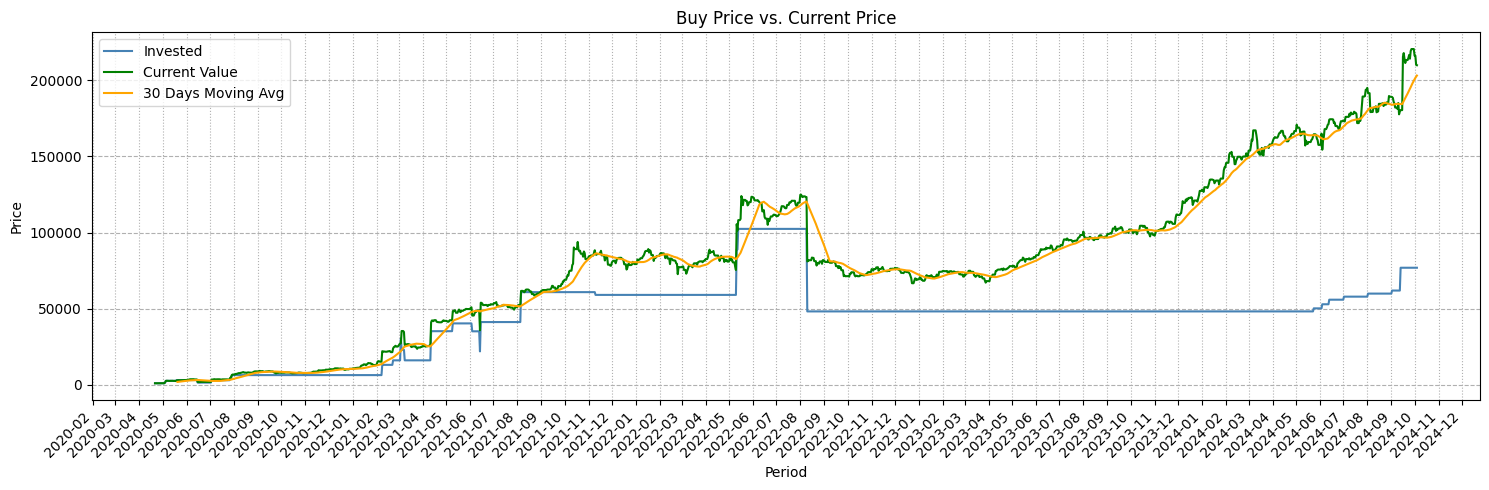

In [5]:
# plot the graph
fig, ax = plt.subplots(figsize=(15, 5))

# plot individual lines
ax.plot(
    df_holding["date"],
    df_holding["holding_amount"],
    label="Invested",
    color="steelblue",
)
ax.plot(
    df_holding["date"],
    df_holding["close_amount"],
    label="Current Value",
    color="green",
)

ax.plot(
    df_holding["date"],
    df_holding["ma30"],
    label="30 Days Moving Avg",
    color="orange",
)

# set major ticks to months and format the ticks
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.grid(True, which="major", linestyle=":")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Add a grid to the y-axis
ax.yaxis.grid(True, which="major", linestyle="--")

# add axis labels and a title
plt.ylabel("Price")
plt.xlabel("Period")
plt.title("Buy Price vs. Current Price")
ax.legend()

# display plot
plt.tight_layout()
plt.show()

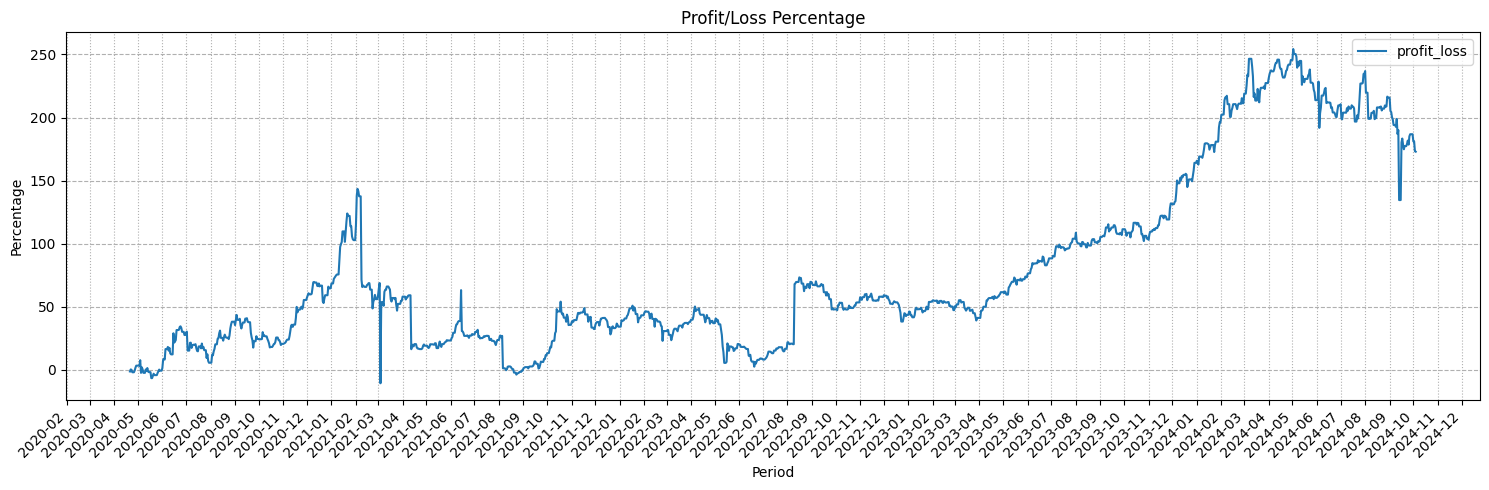

In [6]:
# plot the graph
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_holding["date"], df_holding["pnl_percentage"], label="profit_loss")

# set major ticks to months and format the ticks
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.grid(True, which="major", linestyle=":")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Add a grid to the y-axis
ax.yaxis.grid(True, which="major", linestyle="--")

# add axis labels and a title
plt.ylabel("Percentage")
plt.xlabel("Period")
plt.title("Profit/Loss Percentage")
ax.legend()

# display plot
plt.tight_layout()
plt.show()